# Table of Contents
 <p><div class="lev1"><a href="#Modules,-functions,-results,-variables"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modules, functions, results, variables</a></div><div class="lev1"><a href="#CRM-level-mass-flux"><span class="toc-item-num">2&nbsp;&nbsp;</span>CRM-level mass flux</a></div>

# Modules, functions, results, variables

Modules

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from mpl_toolkits.basemap import Basemap
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from netCDF4 import Dataset
from math import *
import glob
import string
import re
from datetime import date, time, datetime
from pprint import pprint
import sys,os
import csv
import pandas as pd
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths

In [2]:
# Add ../functions to system path
currentpath = %pwd
currentpath = str(currentpath)
##-- In a python script do the following instead:
##-- currentpath = os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0,currentpath[:currentpath.rfind('/')+1]+'functions')

## Fixed data files input directory
inputdir_fx = '/Users/bfildier/Data/preprocessed/allExperiments/fx'
## Dataframe input directory
# resultdir = os.path.join(os.path.dirname(currentpath),'results')
resultdir = os.path.join(os.path.dirname(currentpath),'results/fullResults')
## Maps (2D tropical data files) input directory
inputdir_maps = os.path.join(os.path.dirname(currentpath),'inputs/forMaps')
inputdir_processed = os.path.join(os.path.dirname(currentpath),'inputs/fullDataPreprocessed')

##-- Output directories --##
## Figures
figdir = os.path.join(os.path.dirname(currentpath),'figures/fullResults')


Graphical parameters

In [3]:
###--- Set up graphical parameters ---###

##-- Figure setup --##
plt.rcParams.update({'axes.labelsize': 'x-large',
                     'axes.titlesize': 'x-large',
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'figure.titlesize': 'xx-large',
                     'figure.subplot.top': '0.87',
                     'figure.subplot.wspace': '0.3',
                     'figure.subplot.hspace': '0.3',
                     'legend.fontsize':'medium'})

##-- Load colors for plots --##
colorfile = os.path.join(currentpath,'colorsAndTypes.pickle')
with open(colorfile,'rb') as handle:
    col = pickle.load(handle)
    lt = pickle.load(handle)
    pal = pickle.load(handle)
    lw = pickle.load(handle)
    dashes = pickle.load(handle)
    mark = pickle.load(handle)
    cmaps = pickle.load(handle)

Own modules and functions

In [5]:
from importingData import *
from extremeScaling import *
from thermodynamics import *
from thermo_funcs import *
from thermo_constants import *

Global variables and datasets

In [6]:
###--- Datasets ---###

## Dataset parameter sets and variable sets
compsets = ("FSPCAMm_AMIP","FAMIPC5")
experiments = ("piControl","abrupt4xCO2")
subsets = ("tropics","ocean","land","mfzero")
subsets_for_comp = dict(zip(compsets,(subsets,subsets[:-1])))

## Individual names
compset_SPCAM, compset_CAM5 = compsets
experiment_PI, experiment_4xCO2 = experiments
subset_all, subset_ocean, subset_land, subset_mf = subsets


##--- Related to scaling ---##

## Simulation vs. pr scaling
pr_types = ["simulated","scaling"]
## Contributions to fractional changes
# contributions = ["mass","thermo","dyn_mean","dyn_profile","pressure","non_linear","all"]
# contributions_labs = ["Mass","Thermodynamic",r"Mass flux",r"Profile shift","Pressure","Non linear","Sum"]
contributions = ["thermo","dyn_mean","dyn_mean_th","dyn_mean_dyn","dyn_profile","non_linear","all"]
contributions_labs = ["Thermodynamic",r"Mass flux",r"Mass flux ($\Delta \rho$)",r"Mass flux ($\Delta w$)",
                      r"Profile shift","Non linear","Sum"]
contributions_labels = dict(zip(contributions,contributions_labs))

###--- Variables ids ---###

## All pr ids
pr_ids = ["PRECT","CRM_PREC_I90","CRM_PREC_I75","CRM_PREC_I50","CRM_PREC_I25","CRM_PREC_I10"]
gcm_pr_id = pr_ids[0]
crm_pr_ids = pr_ids[1:]
pr_ids_for_compset = {compsets[0]:pr_ids, compsets[1]:[gcm_pr_id]}

area_id_root = "PRECAREA_"
area_ids = [area_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

frac_id_root = "PRECFRAC_"
frac_ids = [frac_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

## Define IDs of variables required for plotting profiles
varids_for_profiles = {"PRECT":('PS','T','Q','RELHUM','OMEGA','W')}
for f in [90,75,50,25,10]:
#     varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_QC_I%s'%str(f),'CRM_H_I%s'%str(f),
#                                            'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))
    varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'Q','CRM_H_I%s'%str(f),
                                           'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define IDs of variables required for computing scaling
varids_for_scaling = {"PRECT":('PS','T','OMEGA','W')}
for f in [90,75,50,25,10]:
    varids_for_scaling["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

###--- Legends, titles and labels ---###
    
## Corresponding legend labels
compset_labs = ["SPCAM","CAM5"]
compset_labels = dict(zip(compsets,compset_labs))

exp_labs = ["Pre-industrial","4xCO2"]
exp_labels = dict(zip(experiments,exp_labs))

subset_labs = ["Tropics","Tropical oceans","Tropical land","Zero mass flux"]
subset_labels = dict(zip(subsets,subset_labs))

pr_labs = [r"$P(GCM)$",r"$P(CRM)$ largest $90\%$",r"$P(CRM)$ largest $75\%$",r"$P(CRM)$ largest $50\%$",
             r"$P(CRM)$ largest $25\%$",r"$P(CRM)$ largest $10\%$"]
pr_labels = dict(zip(pr_ids,pr_labs))
pr_labs_short = [r"$P(GCM)$",r"${\left[P(CRM)\right]}^{90\%}$",r"${\left[P(CRM)\right]}^{75\%}$",
                 r"${\left[P(CRM)\right]}^{50\%}$",
             r"${\left[P(CRM)\right]}^{25\%}$",r"${\left[P(CRM)\right]}^{10\%}$"]
pr_labels_short = dict(zip(pr_ids,pr_labs_short))
pr_labs_veryshort = [r"$P_{GCM}$",r"$P_{CRM}^{90\%}$",r"$P_{CRM}^{75\%}$",
                 r"$P_{CRM}^{50\%}$",r"$P_{CRM}^{25\%}$",r"$P_{CRM}^{10\%}$"]
pr_labels_veryshort = dict(zip(pr_ids,pr_labs_veryshort))
pr_labs_vvshort = [r"$P_{GCM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$"]
pr_labels_vvshort = dict(zip(pr_ids,pr_labs_vvshort))


###--- Results and others ---###

## Vertical pressure coordinate function
lev_file = 'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'
computeP = getPressureCoordinateFunction(os.path.join(inputdir_fx,lev_file))

## Import all dataframes
# df_quantile = getStatDataFrame("pr_quantile_IL",compsets,experiments,subsets,resultdir)
# df_density2D = getStatDataFrame("pr_jointDensity_IL",compsets,experiments,subsets,resultdir)
# df_mean = getStatDataFrame("var2D_mean",compsets,experiments,subsets,resultdir)
# df_meanProfile = getStatDataFrame("var3D_meanProfile",compsets,experiments,subsets,resultdir)
# df_meanAtQ = getStatDataFrame("var2D_meanAtQ",compsets,experiments,subsets,resultdir)
# df_meanProfileAtQ = getStatDataFrame("var3D_meanProfileAtQ",compsets,experiments,subsets,resultdir)

# CRM-level mass flux

In [18]:
# Import 
pr_id = "CRM_PREC_I50"
pr_ids_to_plot = ["PRECT","CRM_PREC_I50"]
area_id = "I50"
q_id = "999000"
experiment = experiment_PI

def importCRMMassFlux(pr_id,area_id,q_id,experiment,dry=False):
    if dry:
        mf_id = "CRM_MFdry_%s_%s_%s"%(area_id,pr_id,q_id)    
    else:
        mf_id = "CRM_MF_%s_%s_%s"%(area_id,pr_id,q_id)
    print mf_id
    case = "bf_%s_%s"%(compset_SPCAM,experiment)
    inputdir = os.path.join(inputdir_processed,case,'1hr')
    files = getInputfiles(mf_id,inputdir)
    mf_list = getVar(mf_id,inputdir,inputfiles=files)
    inc_list = getVar("isNewCell",inputdir,inputfiles=files)
    return mf_list, inc_list

(1, 33923)
-0.227291756992 -0.584264806663
(1, 30939)
-0.459198976557 -0.9649215404
(1, 5435)
-0.936533083341 -1.2746054915
(1, 6974)
-1.32419697219 -1.82917116975


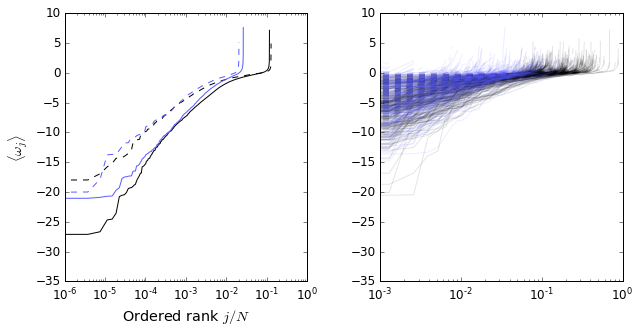

In [98]:
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

for pr_id in pr_ids_to_plot:
    for experiment in experiments:

        mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment)
        print np.hstack(mf_list).shape
        mf_array = np.hstack(mf_list).squeeze()
        print mf_array.mean(), mf_array[mf_array<0].mean()
        inc_array = np.hstack(inc_list).squeeze()
        Ncol = inc_array.size
        Ncells = inc_array.sum()
        mf_array.sort()
        f = np.arange(Ncol)/float(Ncells)/32/24
#         f = np.arange(Ncol)/float(Ncells)
        ax0.plot(f,mf_array,linestyle=lt[experiment],c=col[pr_id])
        ## Plot GCM cell per GCM cell
        for t in range(len(mf_list)):
            for i in range(len(mf_list[i])):
                fi = np.arange(len(mf_list[t][i]))/24./32.
                mf_list[t][i].sort()
                ax1.plot(fi,mf_list[t][i],linestyle=lt[experiment],c=col[pr_id],alpha=0.1)
#                 ax1.plot(fi,mf_list[i])

ax0.set_xscale('log')
ax0.set_xlabel(r'Ordered rank $j/N$')
ax0.set_ylabel(r'$\langle\omega_j\rangle$')

ax1.set_xscale('log')

CRM_PREC_I50 piControl False
CRM_MF_I50_CRM_PREC_I50_999000
CRM_PREC_I50 piControl True
CRM_MFdry_I50_CRM_PREC_I50_999000
/Users/bfildier/Code/python/2016/SpcamExtremes/inputs/fullDataPreprocessed/bf_FSPCAMm_AMIP_piControl/1hr CRM_MFdry_I50_CRM_PREC_I50_999000 None
Error CRM_MFdry_I50_CRM_PREC_I50_999000: no matching input file.
Error isNewCell: no matching input file.
CRM_PREC_I50 abrupt4xCO2 False
CRM_MF_I50_CRM_PREC_I50_999000
CRM_PREC_I50 abrupt4xCO2 True
CRM_MFdry_I50_CRM_PREC_I50_999000


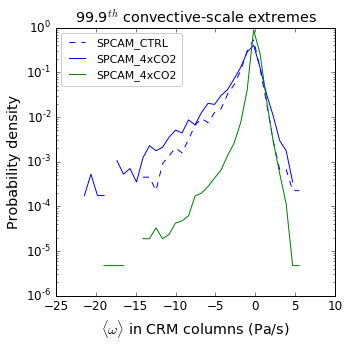

In [25]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]
# pr_ids_to_plot = ["PRECT"]

bins = np.linspace(-30,10,num=50)
labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

c = {False:'b',True:'g'}

for pr_id in pr_ids_to_plot:
    for experiment in experiments:
        for dry in (False, True):
            
            print pr_id, experiment, dry

            mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment,dry)
            if mf_list is None:
                continue
            mf_array = np.hstack(mf_list).squeeze()
            inc_array = np.hstack(inc_list).squeeze()
            Ncol = inc_array.size
            Ncells = inc_array.sum()
            mf_array.sort()
            f = np.arange(Ncol)/float(Ncells)/32/24
            mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
            mf_Hd[mf_Hd == 0] = None
            mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
            # Plot
    #         lab = "%s, for %s"%(exp_labels[experiment],pr_labels_vvshort[pr_id])
            lab = labels[experiment]
            ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[dry],label=lab)

ax0.set_yscale('log')
ax0.set_xlabel(r'$\langle\omega\rangle$ in CRM columns (Pa/s)')
ax0.set_ylabel(r'Probability density')
ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(q_id)/10000.))
ax0.legend(loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=11)

plt.savefig(os.path.join(figdir,"fig_paper_CRMmassfluxPDF_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')

For paper

CRM_MF_I50_CRM_PREC_I50_999000
CRM_MF_I50_CRM_PREC_I50_999000


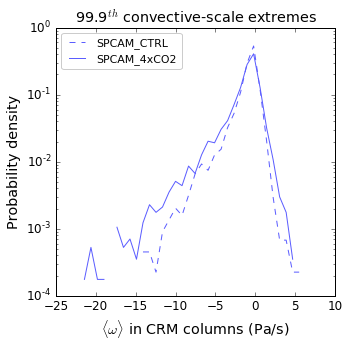

In [21]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]

bins = np.linspace(-30,10,num=50)
labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

for pr_id in pr_ids_to_plot:
    for experiment in experiments:

        mf_list, inc_list = importCRMMassFlux(pr_id,area_id,q_id,experiment)
        mf_array = np.hstack(mf_list).squeeze()
        inc_array = np.hstack(inc_list).squeeze()
        Ncol = inc_array.size
        Ncells = inc_array.sum()
        mf_array.sort()
        f = np.arange(Ncol)/float(Ncells)/32/24
        mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
        mf_Hd[mf_Hd == 0] = None
        mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
        # Plot
#         lab = "%s, for %s"%(exp_labels[experiment],pr_labels_vvshort[pr_id])
        lab = labels[experiment]
        ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=col[pr_id],label=lab)

ax0.set_yscale('log')
ax0.set_xlabel(r'$\langle\omega\rangle$ in CRM columns (Pa/s)')
ax0.set_ylabel(r'Probability density')
ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(q_id)/10000.))
ax0.legend(loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,framealpha=0.2,fancybox=True,fontsize=11)

plt.savefig(os.path.join(figdir,"fig_paper_CRMmassfluxPDF_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')